In [1]:
using Revise # Run this first, if you intend to develop the package

In [2]:
# unnecessary if you follow README
# using Pkg
# Pkg.activate("../QControl")
# Pkg.instantiate()

# Imports

In [3]:
using QControl

┌ Info: Precompiling QControl [edd81335-bcb3-4e33-9681-20bc820459a6]
└ @ Base loading.jl:1423


In [4]:
const QC = QControl;

In [5]:
using QuantumOptics
using PyPlot
using Altro
using ForwardDiff
using LinearAlgebra
using SparseArrays
using RobotDynamics
using TrajectoryOptimization
using StaticArrays
using ForwardDiff
using FiniteDiff
const TO = TrajectoryOptimization
const RD = RobotDynamics
;

# Cavity-Qubit System Setup

In [6]:
# Define bases for cavity (Fock) and atom (Spin-1/2)
const N_CAVITY = 10
const N_QUBIT = 2
const N_FULL = N_CAVITY*N_QUBIT

bq = SpinBasis(1//2)
bc = FockBasis(N_CAVITY - 1)
bfull = bc ⊗ bq
DAC_time_resolution = 1 # ns


# constants (in GHz = cycles / ns)
α = .4
K = 1e-5
χ = 2e-3
D = 1e-3

# operators
a = destroy(bc) ⊗ one(bq)
σx = one(bc) ⊗ sigmax(bq)
σ⁻ = one(bc) ⊗ sigmam(bq) # up -> down, equivalent to creation op
ad = dagger(a)
σ⁺ = dagger(σ⁻)

# base hamiltonian
H₀ = (α/2) * σ⁻ * σ⁻ * σ⁺ * σ⁺
H₀ += (K/2) * ad * ad * a * a
H₀ += χ * ad * a * σ⁻ * σ⁺
H₀ *= 2*π
Hcs = [2*π*D*σx, 2*π*D*(a+ad)];

# binomial code
binomial = Dict("z+" => normalize(fockstate(bc,0) + fockstate(bc,4)), "z-" => fockstate(bc, 2))

# states
ψi = [fockstate(bc, 0) ⊗ spinup(bq)]
ψt = [binomial["z+"] ⊗ spinup(bq)]

;

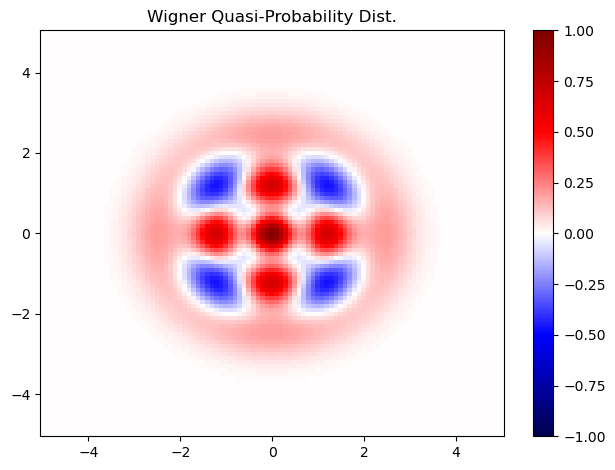

In [64]:
plot_wigner(binomial["z+"])

# Generate Dynamics and Objective

In [8]:
RD.state_dim(::QC.QuantumState), RD.control_dim(::QC.QuantumState), dynamics_func, ψi_state, ψt_state = QC.gen_LQR_params(bfull,H₀, Hcs, ψi, ψt)
RD.dynamics(qs::QC.QuantumState,x,u) = dynamics_func(qs::QC.QuantumState,x,u)
;

In [15]:
model = QC.QuantumState()
state_dim = RD.state_dim(model)
control_dim = RD.control_dim(model)

N = 1001 # number of time steps
tf = 1000.0 # ns, total time
dt = tf / (N-1) # time step

# n_op = sigmap(bq_single)*sigmam(bq_single)
# Q = complex_to_real_isomorphism(n_op.data)
# Q = complex_to_real_isomorphism(one(bq_single).data)
Q = QC.complex_to_real_isomorphism(zeros(N_FULL,N_FULL)*im)

# R = complex_to_real_isomorphism(reshape([1.0 + 0.0*im],(1,1)))
R = QC.complex_to_real_isomorphism(Matrix(0.0001*I(size(Hcs)[1]) .+ 0*im))

I_matrix = QC.complex_to_real_isomorphism(one(bfull).data .+ 0*im)
Qf = (I_matrix - ψt_state*transpose(QC.conj_isomorphism(ψt_state)))
# ⟨ψf|Qf|ψf⟩ = ⟨ψf|(I - |ψt⟩⟨ψt|)|ψf⟩ = 1 - |⟨ψf|ψt⟩|^2

obj = LQRObjective(Q,R,Qf,ψt_state,N);

# Add Constraints

In [16]:
# Add in normalization constraint and goal constraint
cons = ConstraintList(state_dim, control_dim, N)
normcon = NormConstraint(state_dim, control_dim, 1.0, Equality(), :state)
add_constraint!(cons, normcon, N)

goalcon = GoalConstraint(ψt_state)
add_constraint!(cons, goalcon, N)

# Create Problem and Solver

In [17]:
prob = Problem(model, obj, ψi_state, tf, xf=ψt_state, integration=RD.RK4(model));#, constraints=cons);

In [18]:
initial_controls!(prob, [@SVector rand(control_dim) for k = 1:N-1])
rollout!(prob)   # simulate the system forward in time with the new controls

In [19]:
# Set up solver options
opts = SolverOptions()
opts.cost_tolerance = 1e-8

# Create a solver, adding in additional options
solver = ALTROSolver(prob, opts, show_summary=true);

# Solve

In [20]:
solve!(solver);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 348
    Solve Time: 468571.601125 (ms)

  Covergence
    Terminal Cost: 0.016878771905904463
    Terminal dJ: 9.899815654745847e-9
    Terminal gradient: 0.00020663215409111473
    Solve Status: SOLVE_SUCCEEDED


In [22]:
status(solver)

SOLVE_SUCCEEDED::TerminationStatus = 2

In [23]:
println("Number of iterations: ", iterations(solver))
println("Final cost: ", cost(solver))
println("Final constraint satisfaction: ", max_violation(solver)) #TODO: is 1 good??

Number of iterations: 348
Final cost: 0.016878771905904463
Final constraint satisfaction: 1.0


# Parse Data

In [24]:
X = states(solver)     # alternatively states(prob)
U = controls(solver)   # alternatively controls(prob)
Xv = Vector.(X)
Uv = Vector.(U)
Xcv = QC.real_to_complex_isomorphism.(Xv)
Ucv = QC.real_to_complex_isomorphism.(Uv)
Urv = map(cv -> real(cv)[1], Ucv)
Uiv = map(cv -> imag(cv)[1], Ucv)
Uav = map(cv -> norm(cv)[1], Ucv)
Xqv = map(cv -> normalize(Ket(bfull, cv)), Xcv)
;

In [40]:
fidt = map(qv -> abs(dagger(qv)*(binomial["z+"] ⊗ spinup(bq)))^2, Xqv);

# Plots

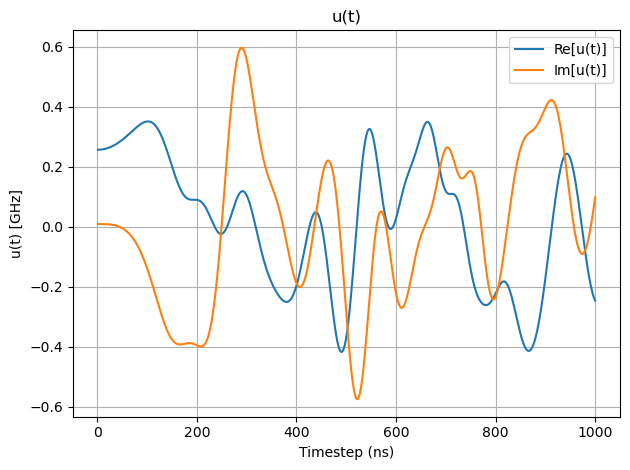

In [56]:
ts = 1:N-1
xlabel("Timestep (ns)")
ylabel("u(t) [GHz]")
title("u(t)")
plot(dt*ts, Urv, label="Re[u(t)]")
plot(dt*ts, Uiv, label="Im[u(t)]")
# plot(dt*ts, Uav, label="|u(t)|")
grid("on")
legend()
tight_layout()

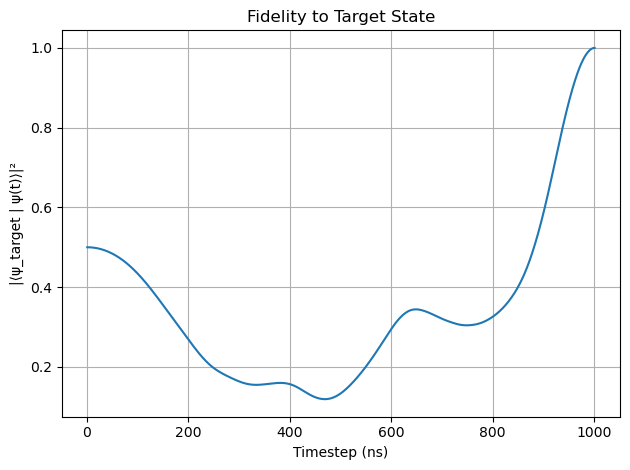

In [44]:
ts = 1:N
plot(dt*ts, fidt)
xlabel("Timestep (ns)")
ylabel("|⟨ψ_target | ψ(t)⟩|²")
title("Fidelity to Target State")
grid("on")
tight_layout()

# 3ns * 1.2 = pi

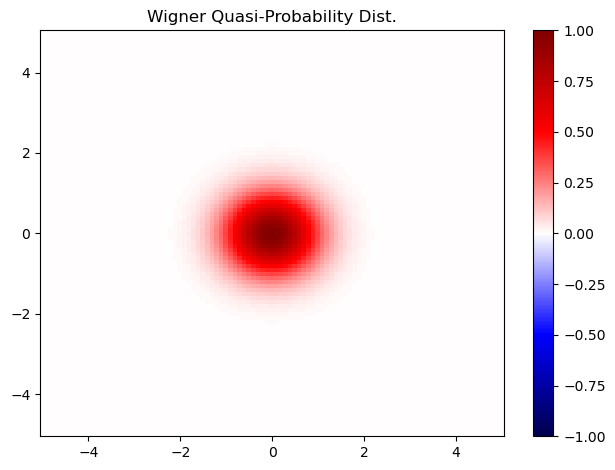

In [62]:
plot_wigner(ptrace(Xqv[1],2))

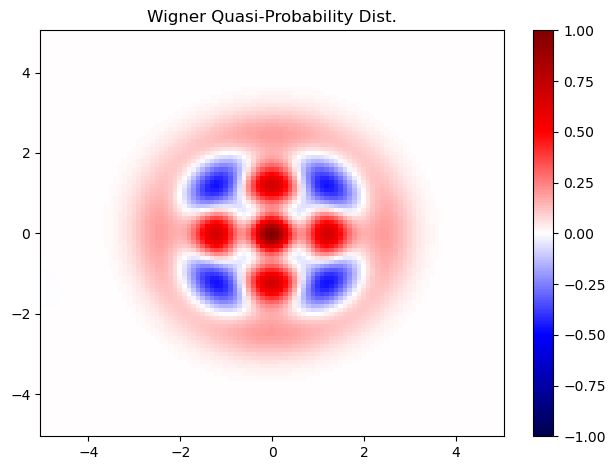

In [54]:
plot_wigner(ptrace(Xqv[end],2))

# References

[1] https://arxiv.org/pdf/1707.01060.pdf (quantum optics)

[2] https://github.com/alec-eickbusch/QOGS (quantum optimal gate synthesis)

[3] https://arxiv.org/pdf/2103.15716.pdf  (robotic quantum optimal control)

[4] https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031006 (binomial code)